# <center>MO444 - Aprendizado de Máquina e Reconhecimento de Padrões</center>
## <center>Primeiro semestre de 2021</center>
## <center>Projeto 1: Aprendizado não supervisionado</center>
## <center>Discentes: Elisa Dell Arriva (135551) e Felipe de Carvalho Pereira (230214)</center>
_________________________________________________________________________

# 1 Introdução

O presente *notebook* consiste no primeiro projeto avaliativo da disciplina MO444 - Aprendizado de Máquina e Reconhecimento de Padrões, ministrada pela Profa. Dra. Esther Colombini. O principal objetivo da atividade foi o de implementar e experimentar métodos de aprendizado não supervisionado e de redução de dimensionalidade para resolver problemas de *clusterização* de dados.<br>

Na primeira parte do projeto, implementamos os algoritmos de clusterização K-means e DBSCAN e aplicamos ambos os métodos em dois *datasets* com diferentes dimensões. Na segunda etapa, utilizamos a técnica de redução de dimensionalidade denominada PCA sobre o *dataset* de maior dimensão e, em seguida, executamos o K-means. Em ambas as etapas, seguimos a especificação do projeto acerca da condução dos experimentos e da avaliação dos resultados.


# 2 *Datasets*

O primeiro *dataset*, ao qual nos referiremos como 2D-dataset, foi fornecido junto com a especificação do projeto e contém 573 *samples* e apenas duas *features* do tipo número real.<br>

O segundo *dataset*, ao qual nos referiremos com Tripadvisor, foi obtido por meio do UCI Machine Learning Repository (disponível em https://archive.ics.uci.edu/ml/datasets/Travel+Reviews). Este *dataset* foi produzido por meio da coleta de avaliações no site tripadvisor.com sobre destinos de viagens (*resorts*, restaurantes, praias, etc.). Cada avaliação do viajante foi mapeada como Excelente (4), Muito boa (3), Média (2), Ruim (1) e Péssimo (0). Para cada um dos 980 usuários, o *dataset* apresenta a avaliação média desse usuário sobre 10 diferentes categorias de destino, quais são:
- Avaliação média do usuário sobre galerias de arte
- Avaliação média do usuário sobre clubes de dança
- Avaliação média do usuário sobre bares de suco
- Avaliação média do usuário sobre restaurantes
- Avaliação média do usuário sobre museus
- Avaliação média do usuário sobre *resorts*
- Avaliação média do usuário sobre parques e locais para piquenique
- Avaliação média do usuário sobre praias
- Avaliação média do usuário sobre cinemas
- Avaliação média do usuário sobre instituições religiosas

Ou seja, o Tripadvisor contém 980 *samples* com 10 *features* do tipo número real. Ao clusterizar os *samples* do *dataset* Tripadvisor, resolvemos o problema de agrupar os usuários de acordo com as avaliações médias destes sobre as 10 categorias descritas.


# 3 Algoritmos

A seguir, apresentamos os algoritmos de clusterização não supervisionados utilizados neste trabalho: K-means e DBSCAN.

## 3.1 K-means

O método K-means pode ser descrito da seguinte maneira. Suponha que tenhamos um *dataset* $d$-dimensional de $n$ *samples* e que desejamos clusterizar os $n$ samples em $k$ *clusters*. Ao longo da execução do algoritmo, manteremos $k$ pontos no espaço $d$-dimensional denominados *centroides*. Como veremos mais à frente, cada centroide determinará um dos $k$ *clusters*. Para estabelecer as coordenadas inicias de cada centroide pode-se escolher, por exemplo, coordenadas aleatórias no espaço $d$-dimensional ou coordenadas iguais às coordenadas de algum *sample* escolhido aleatoriamente.

Em seguida, para cada *sample* $s$, calcula-se a distância (que pode ser a euclidiana) entre $s$ e cada um dos $k$ centroides e, após isso, designa-se $s$ ao centroide que minimiza a distância. Posteriormente, para cada cenroide $c$, atualizamos os valores de todas as suas coordenadas, de modo que o valor de sua $i$-ésima coordenada passa a ser a média dos valores da $i$-ésima coordenada de cada *sample* designado ao centroide $c$. O procedimento descrito neste parágrafo é repetido até que não ocorra alteração nas coordenadas de todos os centroides.

Finalmente, todos os *samples* que foram designados a um mesmo centroide compõem um *cluster*. Como existem $k$ centroides, espera-se que existam exatamente $k$ *clusters* não vazios.

## 3.2 BDSCAN

O DBSCAN (*Density-Based Spatial Clustering of Applications with Noise*) é um algoritmo de aprendizado não-supervisionado da classe dos algoritmos baseados em desidade. Ele consegue identificar *clusters* de formatos arbitrários e, além disso, é capaz de detectar pontos que caracterizam ruído. Para explicar o funcionamento do DBSCAN, precisamos de algumas definições. Para o escopo dessa subseção, chamamos uma *sample* de *nó*. O DBSCAN requer dois parâmetros. O primeiro deles representa um raio de distância, que aqui chamamos de *epsilon*. A *vizinhança* de um nó $x$ é definida como o conjunto dos nós que estão a no máximo uma distância *epsilon* de $x$. 
O segundo parâmetro, que aqui chamamos de *densidade*, determina o número mínimo de pontos que um *cluster* deve ter. Além disso, um nó é classificado como um dentre três tipos, descritos a seguir:
- **core**: se o tamanho de sua vizinhança é maior que o valor do parâmetro densidade;
- **border**: se ele não é core mas tem pelo menos um core em sua vizinhança;
- **noise**: se ele não é border nem core.

Dados um *dataset* e valores de *epsilon* e de densidade, o algoritmo funciona da seguinte maneira. Todos os nós começam marcados como "indefinidos". O algoritmo visita cada nó e, se o nó ainda não foi visitado, ou seja, ainda está marcado como "indefinido", então ele é processado. Seja $x$ um nó que será processado. O algoritmo primeiramente encontra a vizinhança de $x$; se o tamanho de $x$ é maior que a densidade, então $x$ é classificado como *core* e aí inicia-se um novo cluster formado, a princípio, por $x$ e sua vizinhança. Para expandir o cluster, o algoritmo analisa cada vizinho $y$ de $x$. Se a vizinhança de $y$ é maior que a densidade, então $y$ é classificado como *core* e sua vizinhança também deve ser analisada; se, por outro lado, a vizinhança de $y$ é menor que a densidade, então $y$ é classificado como *border* e sua vizinhança não é analisada. 
Agora, no caso em que a vizinhança de $x$ é menor que a densidade, então $x$ não inicia um novo *cluster* e é marcado como *noise* para que ele possa, possivelmente, ser abarcado por algum outro *cluster*.
Sejam **DS** um *dataset*, **EPS** o parâmetro de distância e **D** o parâmetro de densidade. A seguir, mostramos um pseudo-código do algoritmo que implmentamos.

    DBSCAN(DS, EPS, D): 
    para cada NO em DS:
        se NO não foi visitado:
            encontre a vizinhança V de NO
            se o tamanho de V é maior que D:
                classifique NO como core
                inicie um cluster C a partir de NO
            senão:
                classifique NO como noise

Ao final da execução do algoritmo, temos cada nó associado a um *cluster* ou ao rótulo *noise*. Dessa forma, conseguimos definir quais são os *clusters* e quais são os ruídos. 


# 4 Código-fonte

As células a seguir contêm as implementações desenvolvidas pela dupla, incluindo os algoritmos K-means e DBSCAN.

## 4.1 Importação de módulos

In [2]:
# Modules import
import random
import math
import statistics
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import queue

## 4.2 Classes 

In [3]:
#######################################################################################################
#Class that represents a sample
class Sample:
    def __init__(self, identifier, features):
        self.identifier = identifier #Number that identifies the sample
        self.features = features #Array of feature values of the sample
        self.cluster = None #Reference to the object cluster that the sample was assigned
        self.silhouette_a = None #Metric used to calculate the silhouette coefficient
        self.silhouette_b = None #Metric used to calculate the silhouette coefficient
        self.silhouette_score = None #Silhouette coefficient of the sample

        
#######################################################################################################
#Class that represents a centroid
class Centroid:
    def __init__(self, identifier, features):
        self.identifier = identifier #Number that identifies the centroid
        self.features = features #Array of feature values of the centroid
        self.list_of_samples = [] #Array containing all the samples that are assigned to this centroid
        
        
#######################################################################################################
#Class that represents a cluster
class Cluster:
    def __init__(self, identifier, list_of_samples):
        self.identifier = identifier #Number that identifies the cluster
        self.list_of_samples = list_of_samples #Array containing all the samples that are assigned to this cluster
        
        
#######################################################################################################
#Class that represents a node for the DBSCAN method
class DBSCAN_node:
    def __init__(self, sample, label, cluster):
        self.sample = sample 
        self.label = label   # (undefined | noise | core | border)
        self.cluster = cluster # name of the cluster the node belongs to
        self.neighborhood = set()

######################################################################################################## Class of colors to use with the print funtion
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## 4.3 Leitura do dataset, normalizações, métricas de avaliação e geração de gráficos

In [4]:
#######################################################################################################
# Function that reads the dataset from input file
def get_dataset(filename):
    dataset_file = open(filename,"r") #Get the input file
    dataset_file_lines = dataset_file.readlines() #Read all the lines of the input file
    dataset = [] #Array that will contain all samples objects
    
    for i in range(len(dataset_file_lines)): #For each line of the input file
        dataset_file_lines[i] = dataset_file_lines[i].split() #Split the line at the spaces
        features = list(map(float, dataset_file_lines[i])) #Get the features values list in float format
        new_sample = Sample(i+1, features) #Create new Sample object
        dataset.append(new_sample) #Append the new sample to the dataset
        
    return dataset

            
#######################################################################################################
# Function that divides the dataset into training and test sets
def divide_dataset(dataset, training_set_proportion, test_set_proportion):

    training_set_size = math.floor(training_set_proportion*len(dataset)) #Get the size of the training set
    #test_set_size = math.ceil(test_set_proportion*len(dataset)) #Get the size of the test set
    training_set = [] #Traning set array
    test_set = [] #Test set array

    for i in range(len(dataset)): #Partition the dataset into traning and test sets
        if i < training_set_size:
            training_set.append(dataset[i])
        else:
            test_set.append(dataset[i])
    return training_set, test_set

            
#######################################################################################################
# Function that calculates the euclidean distance between two samples
def get_distance(sample1, sample2, n_dimensions):
    sum = 0
    for i in range(n_dimensions):
        sum = sum + (sample1.features[i] - sample2.features[i])**2
    return math.sqrt(sum)

            
#######################################################################################################
# Function that applies the z-score method of normalization and standardization
def z_score_normalization(dataset, n_dimensions):
    for i in range(n_dimensions): #For each dimension i
        feature_values = [] #Create a list of all feature values of the i-th dimension
        for sample in dataset: #Fill the list
            feature_values.append(sample.features[i])
        feature_average = statistics.mean(feature_values) #Get the average value
        feature_stdev = statistics.stdev(feature_values) #Get the standard deviation value
        for sample in dataset: #For each sample, adjust its feature value of the i-th dimension
            sample.features[i] = (sample.features[i] - feature_average)/(feature_stdev) 
            
            
#######################################################################################################            
# Function that applies the min-max method of normalization
def min_max_normalization(dataset, n_dimensions):
    for i in range(n_dimensions): #For each dimension i
        max_value = -math.inf #Maximum value between the feature values of the i-th dimension
        min_value = math.inf #Minimum value between the feature values of the i-th dimension
        for sample in dataset: #Calculate max_value and min_value
            if sample.features[i] > max_value:
                max_value = sample.features[i]
            if sample.features[i] < min_value:
                min_value = sample.features[i]
        for sample in dataset: #For each sample, adjust its feature value of the i-th dimension
            sample.features[i] = (sample.features[i] - min_value)/(max_value - min_value)
            
            
#######################################################################################################            
#Function that plots the elbow graph with repetitions for a each value of k in a given range (Exclusive for K-means)
def plot_elbow_graph(dataset, n_dimensions, min_k, max_k, n_repetitions, title_str):
    
    elbow_points = [] #Points of the elbow graph
    for k in range (min_k, max_k + 1): #For each value of k between min_k and max_k
        average = 0 #Variable that will contain the SSE average value 
        for j in range(n_repetitions): #Execute k-means n_repetitions times with same value of k
            clusters, centroids, sse = kmeans(dataset, k, n_dimensions) #Run the k-means algorithm
            average += sse
        average = float(average)/n_repetitions 
        elbow_points.append([k,average]) #Add the point (k, SSE average value)

    #Plot the graph
    x = []
    y = []
    for point in elbow_points:
        x.append(point[0])
        y.append(point[1])

    plt.xlabel("k")
    plt.ylabel("Média da SSE com " + str(n_repetitions) + " repetições")
    plt.title(title_str)
    plt.xticks(list(range(min_k,max_k + 1)))    
    plt.grid(linestyle='--')
    plt.plot(x,y,'o-')
    plt.show()
    plt.close()
    
    
#######################################################################################################            
# Fuction that calculates the silhouette score of a clusterization
def calculate_silhouette_score(clusters, n_dimensions):
    
    #This loop calculates the "a-score" of each sample
    for cluster in clusters:    #For each cluster C
        for sample in cluster.list_of_samples: #For each sample s in C
            sample.silhouette_a = 0 #Attribute that contains the "a-score" of s
            for sample_in_same_cluster in cluster.list_of_samples: #For each sample s' in C
                if(not(sample.identifier == sample_in_same_cluster.identifier)): #If s != s'
                    sample.silhouette_a += get_distance(sample, sample_in_same_cluster, n_dimensions) #Get the distance between s and s'
            if(len(cluster.list_of_samples) > 1): #If |C| > 1, then calculates the "a-score" of s
                sample.silhouette_a = float(sample.silhouette_a)/(len(cluster.list_of_samples)-1)
    
    #This loop calculates the "b-score" of each sample    
    for cluster in clusters: #For each cluster C
        for sample in cluster.list_of_samples: #For each sample s in C
            min_b = math.inf #Variable that contains the minimum possible "b-score" of s
            for other_cluster in clusters: #For each cluster C'
                if(not(other_cluster.identifier == cluster.identifier)): #If C != C'
                    current_b = 0 #Variable that contains "b-score" of s for C'
                    for sample_in_other_cluster in other_cluster.list_of_samples: #For each sample s' in C'
                        current_b += get_distance(sample, sample_in_other_cluster, n_dimensions) #Get the distance between s and s'
                    current_b = float(current_b)/len(other_cluster.list_of_samples) #Calculates the "b-score" of s related to C'
                    min_b = min(min_b, current_b) #Update the min_b, if it is the case
            sample.silhouette_b = min_b #Attribute that contains the "b-score" of s
            
    silhouette_sample_scores = [] #Array that will contain the score of each sample
    for cluster in clusters: #For each cluster C
        for sample in cluster.list_of_samples: #For each sample s in C
            sample.silhouette_score = (sample.silhouette_b - sample.silhouette_a)/max(sample.silhouette_a,sample.silhouette_b) #Calculates the score of s
            silhouette_sample_scores.append(sample.silhouette_score) #Add the score of s to the array of scores

    silhouette_score = statistics.mean(silhouette_sample_scores) #Calculate the final score of the clusterization, that is the average of all sample scores
    
    return silhouette_score      
            
#######################################################################################################
# Function that plots the average silhouette score for each k in a given range (Exclusive for K-means)
def plot_silhouette_avg_score_graph(dataset, n_dimensions, min_k, max_k, n_repetitions, title_str):
    
    points = [] #Points of the graph
    for k in range(min_k, max_k + 1): #For each value of k between min_k and max_k
        average = 0 #Variable that will contain the silhouette average value for the fixed k
        for i in range(n_repetitions): #Execute k-means n_repetitions times with same value of k
            clusters, centroids, sse = kmeans(dataset, k, n_dimensions) #Run the k-means algorithm
            silhouette_score = calculate_silhouette_score(clusters, n_dimensions) #Get the silhouette score of the clusterization
            average += silhouette_score
        average = float(average)/n_repetitions #Calculates the average score
        points.append([k,average]) #Add the point (k, silhouette average value)
    
    #Plot the graph
    x = []
    y = []
    for point in points:
        x.append(point[0])
        y.append(point[1])

    plt.xlabel("k")
    plt.ylabel("Média do silhouette score com " + str(n_repetitions) + " repetições")
    plt.xticks(list(range(min_k,max_k + 1)))
    plt.title(title_str)
    plt.grid(linestyle='--')
    plt.plot(x,y,'o-', color='green')
    plt.show()
    plt.close()
    
            
#######################################################################################################
# Function that plots the silhouette graph of a given clusterization
def plot_silhouette_graph(dataset, clusters, n_dimensions, k, title_str):
    
    #Calculate the silhouete score
    silhouette_score = calculate_silhouette_score(clusters, n_dimensions)
    
    #The following code plots the silhouette graph and it was adapted from 
    #https://medium.com/neuronio/unsupervised-learning-with-k-means-3eaa0666eebf
    
    silhouette_sample_scores = [] #Array that will contain the score of each sample
    for sample in dataset:
        silhouette_sample_scores.append(sample.silhouette_score) #Add the score of s to the array of scores
    min_silhouette_value = min(-0.1,min(silhouette_sample_scores))
    fig, (ax1) = plt.subplots(1)
    # The 1st subplot is the silhouette plot
    ax1.set_xlim([min_silhouette_value, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(dataset) + (k + 1) * 10])
    # Compute the silhouette scores for each sample
    y_lower = 10
    for i,cluster in enumerate(clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = []
        for sample in cluster.list_of_samples:
            ith_cluster_silhouette_values.append(sample.silhouette_score)
        ith_cluster_silhouette_values.sort()
        size_cluster_i = len(ith_cluster_silhouette_values)
        y_upper = y_lower + size_cluster_i
        #color = plt.cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Rótulo do cluster")
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_score, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    x_ticks = []
    j = 1
    while j > min_silhouette_value:
        x_ticks.append(j)
        j = j - 0.1
    x_ticks.append(min_silhouette_value)
    ax1.set_xticks(x_ticks)
    plt.title(title_str)
    plt.show()
    plt.close()
    
    
#######################################################################################################
#Function that plots a 2D graph of a clusterization
def plot_2D_clusters(clusters, centroids, title_str):
    for cluster in clusters:
        x = []
        y = []
        for sample in cluster.list_of_samples:
            x.append(sample.features[0])
            y.append(sample.features[1])
        plt.scatter(x, y)    
    x = []
    y = []
    for centroid in centroids: #If the centroids of the k-means were given in the input, plot them too
        x.append(centroid.features[0])
        y.append(centroid.features[1])
    plt.scatter(x, y, marker="x", color="black")
    plt.grid(linestyle='--')
    plt.title(title_str)
    plt.show()
    plt.close()

## 4.4 K-Means

In [5]:
#######################################################################################################
#Function that assings each sample to a centroid
def set_clusters(dataset, centroids, dimensions):
    
    for centroid in centroids: #Initialize the list of samples of each centroid as an empty list
        centroid.list_of_samples = []
        
    for sample in dataset: #For each sample
        closest_centroid = None #Variable that will contain the closest centroid
        min_distance = math.inf
        for centroid in centroids: #Check the distance of all centroids and select the closest
            distance = get_distance(sample, centroid, dimensions)
            if distance < min_distance:
                min_distance = distance
                closest_centroid = centroid
        closest_centroid.list_of_samples.append(sample) #Add the sample to the list of samples of the closest centroid


#######################################################################################################
#Function that calculates the Sum of the Squared Error
def get_sse(centroids, dimensions):
    sum = 0
    for centroid in centroids:
        for sample in centroid.list_of_samples:
            sum = sum + get_distance(centroid, sample, dimensions)**2
    return sum


#######################################################################################################
#Function that updates the features values of each centroid
def update_centroids(centroids):
    for centroid in centroids: #For each centroid
        for i in range(len(centroid.features)): #For each feature of the centroid
            centroid.features[i] = 0  
            for j in range(len(centroid.list_of_samples)): #Collected the feature value of each sample assigned to the centroid
                centroid.features[i] += centroid.list_of_samples[j].features[i]
            if(len(centroid.list_of_samples) > 0): #If the cluster is not empty
                centroid.features[i] = centroid.features[i]/float(len(centroid.list_of_samples)) #Apply the average value

                
#######################################################################################################
#Function that implements the k-means clusterization method
def kmeans(dataset, n_clusters, dimensions):
    
    drawed_samples = random.sample(dataset, n_clusters) #Draw n_clusters samples to be the initial centroids
    centroids = [] #Array of centroids
    for i in range(n_clusters): #Add the initial centroids
        new_centroid = Centroid(i+1, drawed_samples[i].features.copy())
        centroids.append(new_centroid)
    
    set_clusters(dataset, centroids, dimensions) #Set the initial clusters
    current_sse = get_sse(centroids, dimensions) #Calculate the inital error value
    sse_converged = False #Flag that indicates if the error value converged
    
    iteration = 1
    #print("Iteration #" + str(iteration))
    #plot_2D_clusters(centroids)
    
    while(not sse_converged): #Main loop of kmeans
        update_centroids(centroids) #Update the centroid features values
        set_clusters(dataset, centroids, dimensions) #Reset the clusters
        new_sse = get_sse(centroids, dimensions) #Get the new error value
        if new_sse < current_sse: #Check if the error value converged
            current_sse = new_sse
        else:
            sse_converged = True
        iteration += 1
        #print("Iteration #" + str(iteration))
        #plot_2D_clusters(centroids)
        
    clusters = []
    i = 1
    for centroid in centroids:
        new_cluster = Cluster(i, centroid.list_of_samples.copy())
        clusters.append(new_cluster)
        for sample in new_cluster.list_of_samples:
            sample.cluster = new_cluster
        i += 1
    
    return clusters, centroids, current_sse


#######################################################################################################
#Function that make a clustrization of the points from the test set using the centroids obtained in the training step
def extend_kmeans_clusterization(centroids, test_set, n_dimensions):
    set_clusters(test_set, centroids, n_dimensions)
    clusters = []
    i = 1
    for centroid in centroids:
        new_cluster = Cluster(i, centroid.list_of_samples.copy())
        clusters.append(new_cluster)
        for sample in new_cluster.list_of_samples:
            sample.cluster = new_cluster
        i += 1
    return clusters

## 4.5 DBSCAN

In [74]:
#######################################################################################################
# Initialyze every node as undefined
def DBSCAN_initialization(dataset):
    DBSCAN_dataset = []
    for sample in dataset:
        new_node = DBSCAN_node(sample, "undefined", -1)
        DBSCAN_dataset.append(new_node)
    
    return DBSCAN_dataset


#######################################################################################################
# Plot the clusterizartion represented by clusters
def DBSCAN_plot_2D_clusters(clusters):
    if len(clusters[0]) <= 0:
        del clusters[0]
    
    for c in clusters:
        x = []
        y = []
        for point in clusters[c]:
            x.append(point.sample.features[0])
            y.append(point.sample.features[1])
        plt.scatter(x, y)    
    plt.show()


#######################################################################################################
# Find the neighborhood in a radius of <eps> of the node <point>
def DBSCAN_find_neighborhood(dataset, dist_func, dim, eps, point):
    neighbors = []
    for n in dataset:
        if dist_func(n.sample, point.sample, dim) <= eps:
            neighbors.append(n)
    
    return set(neighbors)


#######################################################################################################
# Expand the cluster starting inpoint <core>
def DBSCAN_find_cluster(dataset, dist_func, dim, eps, minPoints, core, n_cluster):
    cluster = []
    to_explore = deque()
    
    cluster.append(core)
    to_explore.append(core)
    
    # explore neighborhoods to expand the current cluster
    while len(to_explore) > 0:
        q = to_explore.popleft()
        q.neighborhood = DBSCAN_find_neighborhood(dataset, dist_func, dim, eps, q)          
        
        # classify current point according to the size of its neighborhood
        if len(q.neighborhood) >= minPoints: # current point is core
            q.label = "core" 
            
            # mark each neighbor as part of the current cluster 
            for r in q.neighborhood:
                if r.label == "undefined" or r.label == "noise":
                    r.cluster = n_cluster
                    cluster.append(r)
                    
                    # classify current neighbor according to the size of its neighborhood
                    if len(DBSCAN_find_neighborhood(dataset, dist_func, dim, eps, r)) >= minPoints:
                        r.label = "core"
                    else:
                        r.label = "border"
                    
                    # add neighbor to the queue (if it is not there yet), so its neioghborhood will be analyzed
                    if r not in to_explore:
                        to_explore.append(r)
                
        else: # current point is border  
            q.label = "border" 
    
    return cluster
    

#######################################################################################################
# DBSCAN implementation
def DBSCAN(dataset, dist_func, dim, eps, minDensity):
    # obtain a dataset in the convenient format
    dataset = DBSCAN_initialization(dataset)
    
    # initialize auxiliary variables
    n_clusters = 0   # name of the clusters
    clusters = {}    # clusters obtained as the model
    clusters[0] = [] # list to gather all outliers in one cluster
    
    for point in dataset:
        if point.label == "undefined":
            point.neighborhood = DBSCAN_find_neighborhood(dataset, dist_func, dim, eps, point)
            
            # check neighborhood of the current point
            if len(point.neighborhood) >= minDensity: # neighborhood is large enough, current point is a core point
                point.label = "core"
                
                # start a new cluster
                n_clusters += 1 
                point.cluster = n_clusters
                clusters[n_clusters] = DBSCAN_find_cluster(dataset, dist_func, dim, eps, minDensity, point, n_clusters)
            
            else: # neighborhood not large enough, then classify current point as noise so that it may later be joined in some cluster
                point.label = "noise"
                point.cluster = 0
                    
    # create one cluster for all the outliers
    for point in dataset:
        if point.label == "noise":
            clusters[0].append(point)

    return dataset, clusters  


#######################################################################################################
# Find the distance of the k-nearest neighbors of <point>
def DBSCAN_get_nearest_distances(dataset, dist_func, dim, k, point):
    dist = []
    for q in dataset:
        dist.append(get_distance(q, point, dim))
    
    return sorted(dist)[:k]


#######################################################################################################
# Plot an elbow graph based on the k-nearest neighbors graph
def DBSCAN_plot_elbow_graph(dataset, func_dist, dim, k):
    k_neighbors = {p : [] for p in dataset}
    for p in dataset:
        k_neighbors[p] = DBSCAN_get_nearest_distances(dataset, func_dist, dim, k, p) 

    estimated_eps = [k_neighbors[p][k-1:] for p in training_set]
    estimated_eps = sorted(estimated_eps, reverse=True)

    # plot the elbow graph
    x = [i for i in range(len(estimated_eps))]
    y = estimated_eps
    plt.xlabel("index")
    plt.ylabel("distance")
    plt.plot(x, y, 'g-')    
    plt.show()

#######################################################################################################
# Adjust cluster format (from dictionary to list of object)
def DBSCAN_format_cluster_into_obj(clusters):
    clusters_list = []
    
    c_pairs = clusters.items()
    for p in c_pairs:
        sample_list = []
        for q in p[1]:
            q.sample.cluster = p[0]
            sample_list.append(q.sample)

        clusters_list.append( Cluster(p[0], sample_list) )
    
    if len(clusters_list[0].list_of_samples) <= 0:
        clusters_list = clusters_list[1:]
    
    return clusters_list
   
#######################################################################################################   
# Plot the Silhouette coefficient graph for a set of clusters (model)
def DBSCAN_plot_silhouette_graph(dataset, clusters, dim, eps, title):
    if 0 in clusters:
        del clusters[0]
    
    clusters_list = DBSCAN_format_cluster_into_obj(clusters)
    print("O número de clusters é ", len(clusters_list))
    
    if len(clusters_list) > 1:
        ss = calculate_silhouette_score(clusters_list, dim)
        print("O coeficiente silhouette é ", ss)
        plot_silhouette_graph(dataset, clusters_list, dim, len(clusters_list), title)

#######################################################################################################    
# Runs DBSCAN with a set of different configurations and returns the configuration that reaches the best silhoutte score
def DBSCAN_tune_parameters(dataset, dim, func_dist, densities, radii):
    Score = namedtuple("Score", ["density", "eps"])
    
    SS = {}
    for d in densities:
        # plot elbow
        for r in radii:
            s = Score(density=int(d), eps= r)
            model, clusters = DBSCAN(dataset, func_dist, dim, r, int(d))
            clusters_list = DBSCAN_format_cluster_into_obj(clusters)
            SS[s] = calculate_silhouette_score(clusters_list, dim)
        
    best_score = max(SS, key=SS.get)
    
    return best_score.density, best_score.eps, SS[best_score]

# 5 Experimentos

Nesta seção, apresentamos os experimentos realizados compostos de duas partes, de acordo com a especificação do projeto. Na Seção 5.1, aplicamos os nossos métodos aos dois *datasets* previamente apresentados. Na Seção 5.2, investigamos a utilização de técnicas de redução de dimensionalidade para o Tripadvisor com aplicação do K-means. Por fim, na Seção 5.3, analisamos a influência da inicialização dos centroides no K-means com o 2D-dataset.

Alguns passos da nossa experimentação envolvem a geração de números pseudoaleatórios. Para esse propósito, utilizamos o gerador de números pseudoaletórios do módulo **random**. O trecho de código a seguir inicializa o gerador com uma semente.

In [8]:
seed = 36516285968928
random.seed(seed)


## 5.1 Parte I - Métodos de Clusterização

Esta seção é dividida em duas subseções. Na Subseção 5.1.1, tratamos o 2D-dataset com nossos algoritmos. Já na Seção 5.1.2, tratamos o *dataset* Tripadvisor

### 5.1.1 2D-dataset

Primeiramente, executamos os experimentos previstos na especificação do projeto para o 2D-dataset. O primeiro passo consiste em ler o arquivo de entrada. O *dataset* é armazenado em uma lista
que contém os objetos da classe **Sample**.

In [9]:
TwoD_dataset = get_dataset("cluster.dat") #Read the input and build the dataset
TwoD_n_dimensions = 2 #Set the number of dimensions

Em seguida, aleatorizamos a ordem dos *samples* do 2D-dataset e o dividimos entre conjunto de treinamento e conjunto de teste na proporção 90/10.

In [10]:
random.shuffle(TwoD_dataset) #Randomize the order of the dataset array 
TwoD_training_set, TwoD_test_set = divide_dataset(TwoD_dataset, 0.9, 0.1) #Partition the dataset into training set and test set

Como desconhecemos a distruibuição e o intervalo dos valores das *features* do nosso 2D-dataset, aplicamos o processo de *standardization* denominado *$z$-score normalization* ao conjuno de treinamento.

In [11]:
z_score_normalization(TwoD_training_set, TwoD_n_dimensions) #Apply the z-score normalization

Nesse ponto, o formato da distribuição dos *samples* de treinamento foi modificado, de maneira que para cada *feature*, o valor médio entre todos os *samples* é igual a 0 e o desvio padrão é igual a 1. Como vimos em aula, esse tipo de procedimento é útil em diversos casos e, em particular, quando nossos algoritmos envolvem o uso de distância euclidiana, que é nosso caso. Se não utilizássemos *feature scaling*, poderia ocorrer que alguma das *features* tivesse uma faixa de valores mais ampla que as demais, e nesse cenário a clusterização seria fortemente enviesada por tais *features*.

Agora, utilizaremos o K-means com o 2D-dataset. O próximo passo consiste em determinar o valor mais adequado para o parâmetro $k$, que estabelece o número de *clusters* que será produzido pelo K-means para o 2D-dataset na etapa de treinamento.

É válido ressaltar que estamos utilizando o método Foggy de inicialização de centroides, o qual consiste em escolher as coordenadas iniciais dos centroides como coordenadas de pontos do *dataset* escolhidos de maneira aleatória. A razão pela qual optamos por essa abordagem se deve aos seguintes fatos:
-Alta probabilidade de que cada centroide esteja inicialmente localizado próximo aos *samples*;
-Rápida inicialização dos centroides.

Dito isso, para cada $k \in \{1,2,3, \dots, 10\}$, executamos o K-means 5 vezes. Para cada valor de $k$, computamos a média da *sum of squared error* (SSE) entre as 5 execuções. A SSE é definida como a soma das distâncias euclidianas quadradas de cada *sample* até seu centroide mais próximo. Note que uma vez que trata-se de uma métrica de erro, o objetivo K-means é tentar minimizar esse valor. Utilizando as médias computadas, produzimos um *gráfico cotovelo*, apresentado a seguir.

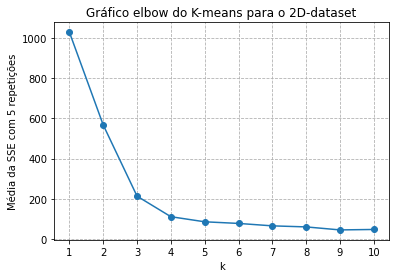

In [10]:
min_k = 1
max_k = 10
n_repetitions = 5
title_str = "Gráfico elbow do K-means para o 2D-dataset"
plot_elbow_graph(TwoD_training_set, TwoD_n_dimensions, min_k, max_k, n_repetitions, title_str) #Plot elbow graph

De acordo com o gráfico acima, os valores de $k$ iguais a 3 e 4 são aqueles em que o gráfico mais se assemelha a um cotovelo. Baseando-se no conteúdo visto em aula, estes valores são os principais candidatos para determinarmos o valor de $k$.

Para corroborar os resultados vistos no gráfico elbow e desempatar a escolha do valor de $k$ entre 3 e 4, utilizamos o *silhouette score*.

O *silhouette score* de uma clusterização é igual à média dos *silhouette coefficents* de todos os *samples*. Por sua vez, o *silhouette coefficent* indica o quão próximo um *sample* é ao em relação ao seu próprio cluster (coesão) em relação à proximidade do *sample* com outros clusters (separação). O coeficiente pertence ao intervalo $[-1,1]$. Quanto mais próximo de 1 é o valor, maior é o indicativo de que o *sample* "combina" com o *cluster* em que ele foi alocado e que não combina com os demais *clusters*. Se a maioria dos *samples* tiver um coeficiente alto, chega-se a que a *clusterização* foi feita de maneira apropriada. Se muitos *samples* tiverem um valor baixo ou negativo, é possível que a clusterização possua uma quantidade de *clusters* abaixo ou acima do ideal.

Para cada $k \in \{2,3, \dots, 10\}$, executamos o K-means 5 vezes para cada valor de $k$, computamos a média do *silhouette score* entre as 5 execuções. Utilizando as médias cumputadas, produzimos o gráfico apresentado a seguir.

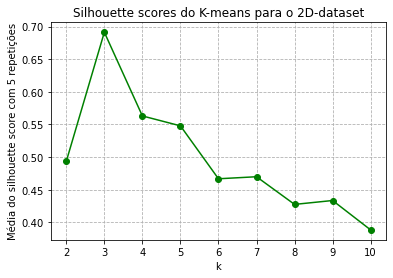

In [11]:
min_k = 2
max_k = 10
n_repetitions = 5
title_str = "Silhouette scores do K-means para o 2D-dataset"
plot_silhouette_avg_score_graph(TwoD_training_set, TwoD_n_dimensions, min_k, max_k, n_repetitions, title_str) #Plot silhouette average score graph

Do gráfico acima podemos concluir que para $k = 3$ a média do *silhouette score* é de aproximadamente 0.69 e este é o maior valor obtido para o intervalo testado. O segundo maior *score* é de aproximadamente 0.56 e, portanto, há uma discrepância considerável nos *scores* obtidos para $k = 3$ e $k = 4$. Portanto, para conduzir a etapa de treinamento, escolhemos $k = 3$.

O próximo passo consiste em executar o K-means com o conjunto de treinamento.

In [20]:
k = 3
TwoD_training_clusters, TwoD_training_centroids, TwoD_training_sse = kmeans(TwoD_training_set, k, TwoD_n_dimensions) #Execute k-means with training set

Como temos apenas duas dimensões no 2D-dataset, podemos visualizar a clusterização feita para o conjunto de treinamento.

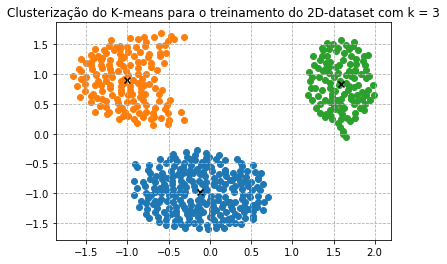

In [21]:
title_str = "Clusterização do K-means para o treinamento do 2D-dataset com k = 3"
plot_2D_clusters(TwoD_training_clusters, TwoD_training_centroids, title_str)

Na figura acima, podemos os *samples* coloridos com a mesma cor pertencem ao mesmo *cluster*. Claramente há 3 *clusters* e os centroides associados a cada um dos *clusters* estão demarcados com uma cruz preta.

Para avaliar a qualidade da clusterização feita pelo K-means para o conjunto de treino do 2D-dataset, calculamos o *silhouette score* da clusterização.

In [22]:
silhouette_score = calculate_silhouette_score(TwoD_training_clusters, TwoD_n_dimensions)
print("Silhouette score da clusterização do K-means para o treinamento do 2D-dataset com k = 3: " + str(silhouette_score))

Silhouette score da clusterização do K-means para o treinamento do 2D-dataset com k = 3: 0.6912445644970896


Apresentamos também o gráfico *silhouette* da clusterização.

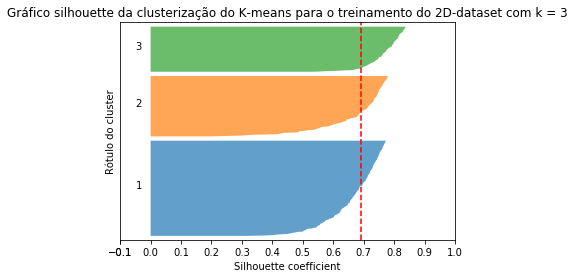

In [23]:
title_str = "Gráfico silhouette da clusterização do K-means para o treinamento do 2D-dataset com k = 3"
plot_silhouette_graph(TwoD_training_set, TwoD_training_clusters, TwoD_n_dimensions, k, title_str)

No gráfico acima, cada barra horizontal representa o *silhouette coefficent* de um *sample* de acordo com a clusterização. As barras estão agrupadas por *cluster* e a linha tracejada vertical indica o *silhouette score* da clusterização. Desse *plot*, chegamos que no geral, os *samples* alcançaram coeficientes próximos da média. Em particular, quase a totalidade dos *samples* do *cluster* 1 ficaram apresentaram coeficiente acima da média. Isso indica que embora os três *clusters* apresentem boa coesão, o mais coeso deles é o *cluster* 1. Esse resultado está de acordo com o gráfico anterior que apresenta a clusterização. Note que os pontos do *cluster* 1 são aqueles que, no gerla, estão mais afastados dos demais *clusters* e mais próximos entre si.

A próxima etapa, a etapa de teste, é passo final para a utilização do K-means com o 2D-dataset. Nesse caso utilizamos os centroides obtidos no treinamento para clusterizar os *samples* do conjunto de teste. Primeiramente, aplicamos o *$z$-score normalization* para o conjunto de teste, assim como fizemos para o conjunto de treinamento.

In [24]:
z_score_normalization(TwoD_test_set, TwoD_n_dimensions) #Apply the z-score normalization

Em seguida, fazemos o que segue. Para cada *sample* do conjunto de teste, verificamos qual é o centroide mais próximo e alocamos o *sample* nesse centroide.

In [25]:
TwoD_test_clusters = extend_kmeans_clusterization(TwoD_training_centroids, TwoD_test_set, TwoD_n_dimensions)

Como temos apenas duas dimensões no 2D-dataset, podemos visualizar a clusterização feita para o conjunto de teste.

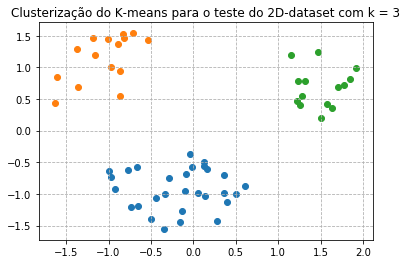

In [26]:
title_str = "Clusterização do K-means para o teste do 2D-dataset com k = 3"
plot_2D_clusters(TwoD_test_clusters, [], title_str)

Em seguida calculamos o *silhouette score* da clusterização dos *samples* de teste e exibimos o seu gráfico *silhouette*.

Silhouette score da clusterização do K-means para o teste do 2D-dataset com k = 3: 0.702169545602683


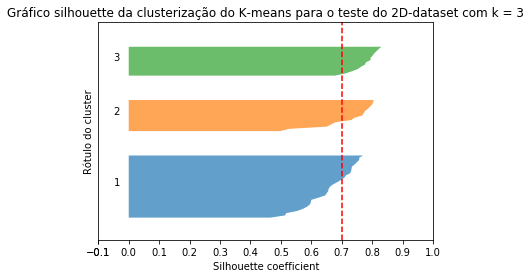

In [27]:
silhouette_score = calculate_silhouette_score(TwoD_test_clusters, TwoD_n_dimensions)
print("Silhouette score da clusterização do K-means para o teste do 2D-dataset com k = 3: " + str(silhouette_score))
title_str = "Gráfico silhouette da clusterização do K-means para o teste do 2D-dataset com k = 3"
plot_silhouette_graph(TwoD_test_set, TwoD_test_clusters, TwoD_n_dimensions, k, title_str)

De acordo com o gráfico acima, a qualidade da clusterização do conjunto de teste foi ligeiramente melhor, na média, que a qualidade da clusterização do conjunto de treinamento. Além disso, os resultados obtidos para os *clusters* de teste são bastante semelhantes com aqueles obtidos na etapa de treinamento.

Agora, repetimos o mesmo procedimento com o DBSCAN. Para dispor de bases consistentes para posterior comparação entre os dois métodos, utilizaremos os mesmos conjuntos de treinamento e de teste. Sendo assim, podemos passar para a etapa de calibrar os hiper-parâmetros do DBSCAN, isto é, a densidade e a distância. 
De acordo com a principal fonte que consultamos para aprender sobre o DBSCAN (https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html), o valor de densidade mínima deve ser maior que 2, caso contrário o DBSCAN teria um comportamento similar ao de clusterização por hierarquia, o que não é o que buscamos aqui. Mais ainda, é dito que uma boa regra é tomar a densidade mínima como sendo duas vezes a dimensão do dataset. Em nossos experimentos, utilizamos tal regra. Em seguida, testamos essa densidade com uma lista de 50 valores uniformemente distribuídos entre 0.1 e 10. A ideia é conseguir testar tanto distâncias curtas como longas.

In [51]:
# set interval of values for the hiper-parameters to be tested
dim = 2
density_interval = np.linspace(2*dim, 2*dim, 1)
eps_interval = np.linspace(0.1, 10, 50)

# find best configuration of parameters according to silhouette score
best_d, best_e, best_ss = DBSCAN_tune_parameters(TwoD_training_set, 2, get_distance, density_interval, eps_interval)
print("A melhor configuração foi: densidade mínima = ", best_d, "e distância = ", best_e, "obtendo coeficiente igual a ", best_ss)

A melhor configuração foi: densidade mínima =  4 e distância =  0.3020408163265306 obtendo coeficiente igual a  0.6912445644970896


Uma vez com os hiper-parâmetros ajustados, rodamos o DBSCAN e, em seguida, o coeficiente *silhouette*.

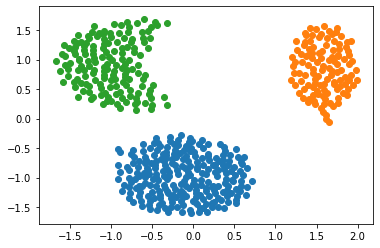

O número de clusters é  3 coeficiente silhouette é  0.6912445644970896


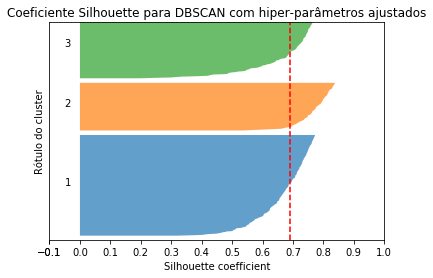

In [52]:
# runs DBSCAN using the appropiate values of epsilon (best_e) and density (best_d)
model, clusters = DBSCAN(TwoD_training_set, get_distance, 2, best_e, best_d)

# plot the clusterization and the Silhouette coefficient
DBSCAN_plot_2D_clusters(clusters) 
DBSCAN_plot_silhouette_graph(TwoD_training_set, clusters, 2, best_e, "Coeficiente Silhouette para DBSCAN com hiper-parâmetros ajustados")

Uma vez adquirido um modelo, partimos para classificar o dataset de teste. Nossa abordagem foi: para cada nó do dataset de teste, buscar qual seria sua vizinhança se ele estivesse no dataset de treinamento, em seguida, contar quantos vizinhos de cada cluster aparecem na vizinhança dele e, por fim, atribuir o nó sendo analisado ao cluster que aparece com mais fequência nessa vizinhança. A seguir, rodamos esse experimento com o dataset de teste, utilizando como referência o modelo obtido acima com a configuração que gerou o melhor silhouette score. Plotamos a clusterização e o coeficiente silhouette para o resultado obtido.

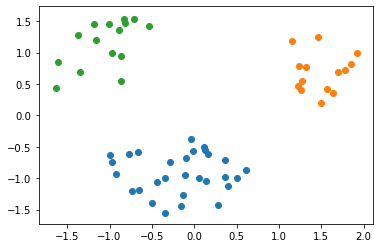

O número de clusters é  3 coeficiente silhouette é  0.702169545602683


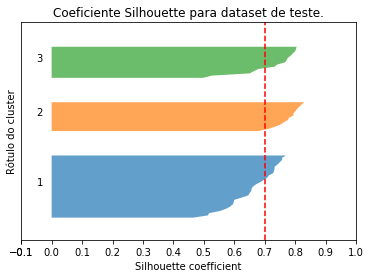

In [57]:
# initialization of data set and auxiliary variables
v_set = DBSCAN_initialization(TwoD_test_set)
neighbors_count = {key: 0 for key in range(0,50)}
v_clusters = {key: [] for key in range(0,50)}

# get model generated by training the training set
model, clusters_2 = DBSCAN(TwoD_training_set, get_distance, 2, best_e, best_d)  

# classify each point of the test set one of the clusters of the model
for v_point in v_set:
    # get neighborhood of the current point as if it was placed in the model set
    v_neighborhood = DBSCAN_find_neighborhood(model, get_distance, 2, best_e, v_point)
    
    # count the number of neighbors of each cluster
    for q in v_neighborhood:
        neighbors_count[q.cluster] += 1
    
    # set current point to the "most frequent" cluster in its "model neighborhood"
    v_point.cluster = max(neighbors_count, key=neighbors_count.get)
    
    # reset the counter of neighbors of each cluster
    neighbors_count = {key: 0 for key in neighbors_count}
    
# construct the dictionary with all clusters and plot the result
for p in v_set:
    v_clusters[p.cluster].append(p)

# plot the clusterization
DBSCAN_plot_2D_clusters(v_clusters)

# delete unused clusters
delete = [k for k,l in v_clusters.items() if len(l)==0]
for d in delete:
    del v_clusters[d]

# plot the silhouette coeffcient grapph
DBSCAN_plot_silhouette_graph(TwoD_test_set, v_clusters, 2, best_e, "Coeficiente Silhouette para dataset de teste.")

O coeficiente silhouette para a fase de treinamento, com os melhores valores para os hiper-parâmetros atingiu valor 0.6912445644970896 e, na fase de teste, o coeficiente atingiu o valor 0.702169545602683. Isso que a fase de teste obteve bons resultados quando comparado ao treinamento. O número de clusters foi o mesmo nas duas fases e, como pode ser observado nos gráficos de clusterização, a distribuição dos clusters no plano também são similares. 

### 5.1.2 Tripadvisor

Nesta seção, repetiremos o experimento realizado na seção anterior, mas utilizando o *dataset* Tripadvisor, o qual possui 10 dimensões. Primeiramente, carregamos o *dataset*, o dividimos entre conjunto de treinamento e de teste e aplicamos o processo de *standardization* com o conjunto de treinamento.

In [38]:
Tripadvisor_dataset = get_dataset("trip_advisor.dat") #Read the input and build the dataset
Tripadvisor_n_dimensions = 10 #Set the number of dimensions
random.shuffle(Tripadvisor_dataset) #Randomize the order of the dataset array 
Tripadvisor_training_set, Tripadvisor_test_set = divide_dataset(Tripadvisor_dataset, 0.9, 0.1) #Partition the dataset into training set and test set
z_score_normalization(Tripadvisor_training_set, Tripadvisor_n_dimensions) #Apply the z-score normalization

Em seguida, obtemos o gráfico *elbow* com $k \in \{1,2,3, \dots, 10\}$.

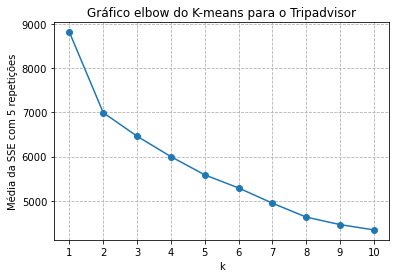

In [27]:
min_k = 1
max_k = 10
n_repetitions = 5
title_str = "Gráfico elbow do K-means para o Tripadvisor"
plot_elbow_graph(Tripadvisor_training_set, Tripadvisor_n_dimensions, min_k, max_k, n_repetitions, title_str) #Plot elbow graph

De acordo com o gráfico acima, o "cotovelo" ocorre para $k = 2$. Para corroborar o resultado vistos no gráfico *elbow* plotamos também o gráfico da média do *silhouette score* com $k \in \{1,2,3, \dots, 5\}$.

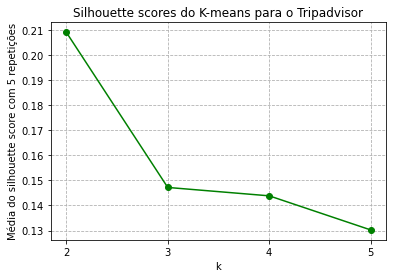

In [28]:
min_k = 2
max_k = 5
n_repetitions = 5
title_str = "Silhouette scores do K-means para o Tripadvisor"
plot_silhouette_avg_score_graph(Tripadvisor_training_set, Tripadvisor_n_dimensions, min_k, max_k, n_repetitions, title_str) #Plot silhouette average score graph

Como a maior média do *silhouette score* ocorre para $k = 2$, o resultado do gráfico *elbow* foi corroborado e escolhemos $k = 2$ para executar o treinamento, o qual segue.

In [29]:
k = 2
Tripadvisor_training_clusters, Tripadvisor_training_centroids, Tripadvisor_training_sse = kmeans(Tripadvisor_training_set, k, Tripadvisor_n_dimensions) #Execute k-means with training set

Para avaliar a qualidade da clusterização feita pelo K-means para o conjunto de treino do 2D-dataset, calculamos o *silhouette score* da clusterização.

In [30]:
silhouette_score = calculate_silhouette_score(Tripadvisor_training_clusters, Tripadvisor_n_dimensions)
print("Silhouette score da clusterização do K-means para o treinamento do Tripadvisor com k = 2: " + str(silhouette_score))

Silhouette score da clusterização do K-means para o treinamento do Tripadvisor com k = 2: 0.2062016170340067


Apresentamos também o gráfico *silhouette* da clusterização.

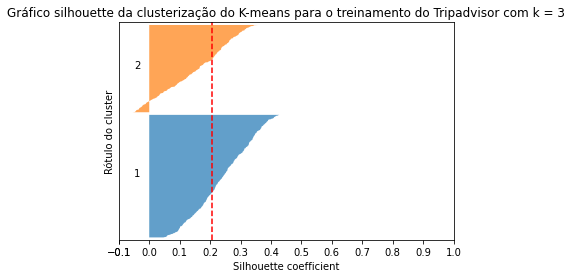

In [25]:
title_str = "Gráfico silhouette da clusterização do K-means para o treinamento do Tripadvisor com k = 3"
plot_silhouette_graph(Tripadvisor_training_set, Tripadvisor_training_clusters, Tripadvisor_n_dimensions, k, title_str)

De acordo com o gráfico *silhouette*, o K-means obtive o desempenho baixo, com um *silhouette score* próximo de 0.2. Observe que embora todos os *samples* do cluster 1 possuam coeficientes positivos, para o *cluster* 2, existem *samples* com coeficientes negativos.

Agora, vamos rodar o mesmo experimento, mas utilizando o algoritmo DBSCAN.
No caso do *dataset* *TripAdvisor*, como a dimensão é maior, nós optamos por dar uma margem de possíveis valores de densidade e, então, ao invéz de fixar a densidade em 20 (duas vezes a dimensão), nós testamos para densidade igual a 10 e para densidade igual a 20. 
Além disso, porque o *dataset* é muito extenso, diminuímos a quantidade de valores de distância testados. Para cada valor de densidade, testamos 10 valores de distância, distribuídos uniformemente no intervalo de 1 a 10.
Abaixo está a rotina de calibragem dos parâmetros.

In [69]:
# set interval of values for the hiper-parameters to be tested
dim = 10
density_interval = np.linspace(dim, 2*dim, 2)
eps_interval = np.linspace(1, 10, 10)

# find best configuration of parameters according to silhouette score
trip_best_d, trip_best_e, trip_best_ss = DBSCAN_tune_parameters(Tripadvisor_training_set, 10, get_distance, density_interval, eps_interval)
print("A melhor configuração foi: densidade mínima = ", trip_best_d, "e distância = ", trip_best_e, "obtendo coeficiente igual a ", trip_best_ss)

A melhor configuração foi: densidade mínima =  20 e distância =  5.0 obtendo coeficiente igual a  0.5829847554531374


Note que, apesar de termos dado a possibilidade de a densidade ser 10, o melhor resultado foi com uma configuração em que a densidade é, de fato, 20 (ou seja, duas vezes a dimensão do *dataset*).

Em seguida, rodamos o DBSCAN com os melhores valores encontrados para os hiper-parâmentros e plotamos o gráfico do coeficiente *silhouette*.

In [78]:
# runs DBSCAN using the appropiate values of epsilon (best_e) and density (best_d)
trip_model, trip_clusters = DBSCAN(Tripadvisor_training_set, get_distance, 10, trip_best_e, trip_best_d)

print("O número de outliers é ", len(trip_clusters[0]))

# plot the clusterization and the Silhouette coefficient
DBSCAN_plot_silhouette_graph(Tripadvisor_training_set, trip_clusters, 10, trip_best_e, "Coeficiente Silhouette para DBSCAN com hiper-parâmetros ajustados")


O número de outliers é  2
O número de clusters é  1


Note que o nosso treinamento resultou em apenas um *cluster* e, por isso, não faz sentido plotar o gráfico do coeficiente *silhouette*. 
Uma vez que obtivemos um modelo referência, utilizamos o mesmo processo aplicado no caso 2d para clusterizar o conjunto de testes. 

In [80]:
# initialization of data set and auxiliary variables
trip_v_set = DBSCAN_initialization(Tripadvisor_test_set)
trip_neighbors_count = {key: 0 for key in range(0,50)}
trip_v_clusters = {key: [] for key in range(0,50)}

# classify each point of the test set one of the clusters of the model
for v_point in trip_v_set:
    # get neighborhood of the current point as if it was placed in the model set
    v_neighborhood = DBSCAN_find_neighborhood(trip_model, get_distance, 10, trip_best_e, v_point)
    
    # count the number of neighbors of each cluster
    for q in v_neighborhood:
        trip_neighbors_count[q.cluster] += 1
    
    # set current point to the "most frequent" cluster in its "model neighborhood"
    v_point.cluster = max(trip_neighbors_count, key=trip_neighbors_count.get)
    
    # reset the counter of neighbors of each cluster
    trip_neighbors_count = {key: 0 for key in trip_neighbors_count}
    
# construct the dictionary with all clusters and plot the result
for p in trip_v_set:
    trip_v_clusters[p.cluster].append(p)

print("O número de outliers é ", len(trip_v_clusters[0]))
# delete unused clusters
delete = [k for k,l in trip_v_clusters.items() if len(l)==0]
for d in delete:
    del trip_v_clusters[d]

# plot the silhouette coeffcient grapph
DBSCAN_plot_silhouette_graph(Tripadvisor_test_set, trip_v_clusters, 10, trip_best_e, "Coeficiente Silhouette para dataset de teste.")

O número de outliers é  1
O número de clusters é  1


No conjunto de testes, o resultado também foi um único *cluster* e, por isso, não há plot do coeficiente *silhouette* nesse caso. 
Contudo, apesar de não termos os gráficos de tais coeficientes, é possível concluir que os resultados obtidos no conjunto de teste foi compatível com o resultado obtifo no conjunto de treinamento; ambos resultaram em apenas um clusters e poucos outliers, implicando que conseguimos um bom resultado após o treinamento.

Falta agora comparar os resultados encontrados para o *dataset* *TripAdvisor* aplicando o *k-means* com os resultados encontrados aplicanso o DBSCAN.

## 5.2 Parte II - Redução de Dimensionalidade

## 5.3 Inicialização de Centroides

# 6 Considerações Finais

### Algumas observações sobre o DBSCAN
O desafio maior que o DBSCAN nos impôs foi o de ajustar seus parâmetros de entrada, especialmente pelo fato de serem dois deles. 
Para estimar um bom conjunto de parâmetros, nossa abordagem foi rodar o algoritmo com várias combinações diferentes, calcular o *silhouette score* para cada uma delas e, por fim, escolher a combinação que apresentou o melhor *score*.
Para definir o intervalo de valores a ser considerado para a densidade, partimos da ideia, comum na literatura, de considerar duas vezes a dimensão do *dataset*. A dificuldade maior veio em estimar o valor do parâmetro de distância, pois não sabíamos de onde partir. Uma ideia foi a de utilizar o grafo dos $k$ vizinhos mais próximos para tentar estimar um raio conveniente, testanto vários valores de $k$. Nosssa ideia era plotar como $k$ valores que fóssemos tomar como a densidade e observar os resutlados. Contudo, não conseguimos finalizar esse experimento em tempo hábil e, por isso, seguimos uma abordagem mais direta: optamos por considerar um intervalo grande de valores, de forma a garantir que distâncias curtas e longas estejam sendo consideradas.

### Participação individual
Ambos discentes participaram ativamente durante todo o projeto. Em termos de implementação, Felipe lidou mais diretamente com o código da parte relacionadas ao k-means, enquanto Elisa lidou mais diretamente com a parte do DBSCAN. Contudo, as pesquisa e discussões foram sempre feitas em conjunto.  

# 7 Referências Bibliográficas


### DBSCAN
Foram usadas como referência duas fontes pricipais, as quais:
- https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html
- https://en.wikipedia.org/wiki/DBSCAN



### K-means com dataset bidimensional

In [ ]:
"""
#Testing K-means with 10-dimensional dataset
dataset = get_dataset("trip_advisor.dat") #Build the dataset
n_dimensions = 10
random.shuffle(dataset) #Randomize the dataset array
#min_max_normalization(dataset, n_dimensions) #Apply the min-max normalization
z_score_normalization(dataset, n_dimensions) #Apply the z-score normalization
training_set, test_set = divide_dataset(dataset, 0.9, 0.1) #Partition the dataset into training set and test set
plot_elbow_graph(training_set, n_dimensions,1, 10, 5) #Plot elbow graph
plot_silhouette_avg_score_graph(training_set,n_dimensions, 2, 10, 5) #Plot silhouette average score graph

for k in [2]:
    clusters, centroids, sse = kmeans(training_set, k, n_dimensions)
    plot_silhouette_graph(training_set, clusters, n_dimensions, k)
    clusters_test_set = extend_kmeans_clusterization(centroids, test_set, n_dimensions)
    plot_silhouette_graph(test_set, clusters_test_set, n_dimensions, k)
"""

### DBSCAN com dataset bidimensional

In [ ]:
# Get dataset
ds_filepath = "cluster.dat"
ds = get_dataset(ds_filepath)

# Pre-process and divide the dataset into training and test sets
random.seed(135551) 
random.shuffle(ds) 
training_set, test_set = divide_dataset(ds, 0.9, 0.1)
z_score_normalization(training_set, 2)
z_score_normalization(test_set, 2)

# set hiper-parameters with the appropiate values
density_interval = np.linspace(2*dim, 5*dim, 5)
eps_interval = np.linspace(0.1, 2, 15)

# find best parameters according to silhouette score
best_d, best_e, best_ss = DBSCAN_tune_parameters(training_set, 2, get_distance, density_interval, eps_interval)

# runs DBSCAN using the appropiate values of epsilon (best_e) and density (best_d)
model, clusters = DBSCAN(training_set, get_distance, 2, best_e, best_d)

# plot the clusterization and the Silhouette coefficient
DBSCAN_plot_2D_clusters(clusters)
DBSCAN_plot_silhouette_graph(training_set, clusters, 2, best_e)

In [ ]:
# initialization of data set and auxiliary variables
v_set = DBSCAN_initialization(test_set)
neighbors_count = {key: 0 for key in range(0,50)}
v_clusters = {key: [] for key in range(0,50)}

# get model generated by training the training set
model, clusters_2 = DBSCAN(training_set, get_distance, 2, best_e, best_d)  

# classify each point of the test set one of the clusters of the model
for v_point in v_set:
    # get neighborhood of the current point as if it was placed in the model set
    v_neighborhood = DBSCAN_find_neighborhood(model, get_distance, 2, best_e, v_point)
    
    # count the number of neighbors of each cluster
    for q in v_neighborhood:
        neighbors_count[q.cluster] += 1
    
    # set current point to the "most frequent" cluster in its "model neighborhood"
    v_point.cluster = max(neighbors_count, key=neighbors_count.get)
    
    # reset the counter of neighbors of each cluster
    neighbors_count = {key: 0 for key in neighbors_count}
    
# construct the dictionary with all clusters and plot the result
for p in v_set:
    v_clusters[p.cluster].append(p)

# plot the clusterization
DBSCAN_plot_2D_clusters(v_clusters)

# delete unused clusters
delete = [k for k,l in v_clusters.items() if len(l)==0]
for d in delete:
    del v_clusters[d]

# plot the silhouette coeffcient grapph
DBSCAN_plot_silhouette_graph(test_set, v_clusters, 2, best_e)

### DBSCAN com dataset 10-dimensional

In [ ]:
# Get dataset
ds_filepath = "trip_advisor.dat"
ds = get_dataset(ds_filepath)
dim = len(training_set[0].features) # get the number of features of the dataset

# Pre-process the dataset
random.seed(37154) 
random.shuffle(ds)
training_set, test_set = divide_dataset(ds, 0.9, 0.1) 
z_score_normalization(training_set, dim)
z_score_normalization(test_set, dim)

# set hiper-parameters with the appropiate values
density_interval = np.linspace(2*dim, 5*dim, 5)
eps_interval = np.linspace(0.1, 10)

# find best parameters according to silhouette score
best_d, best_e, best_ss = DBSCAN_tune_parameters(training_set, dim, get_distance, density_interval, eps_interval)
print("d=", best_d, "e=", best_e)
# runs DBSCAN using the appropiate values of epsilon (best_e) and density (best_d)
model, clusters = DBSCAN(training_set, get_distance, dim, 6, 20)

# plot the clusterization and the Silhouette coefficient
#DBSCAN_plot_2D_clusters(clusters)
if len(clusters[0]) <= 0:
    del clusters[0]

DBSCAN_plot_silhouette_graph(training_set, clusters, dim, best_e)

In [ ]:
# initialization of data set and auxiliary variables
v_set = DBSCAN_initialization(test_set)
neighbors_count = {key: 0 for key in range(0,len(test_set))}
v_clusters = {key: [] for key in range(0,len(test_set))}

# run through each point of the test set so as to classify them
for v_point in v_set:
    # get neighborhood of the current point as if it was placed in the model set
    v_neighborhood = DBSCAN_find_neighborhood(model, get_distance, dim, best_e, v_point)
    
    # count the number of neighbors of each cluster
    for q in v_neighborhood:
        neighbors_count[q.cluster] += 1
    
    # set current point to the "most frequent" cluster in its "model neighborhood"
    v_point.cluster = max(neighbors_count, key=neighbors_count.get)
    
    # reset the counter of neighbors of each cluster
    neighbors_count = {key: 0 for key in neighbors_count}
    
# construct the dictionary with all clusters and plot the result
for p in v_set:
    v_clusters[p.cluster].append(p)
    
# delete unused clusters
delete = [k for k,l in v_clusters.items() if len(l)==0]
for d in delete:
    del v_clusters[d]

# plot the silhouette coeffcient grapph
DBSCAN_plot_silhouette_graph(test_set, v_clusters, dim, best_e)
    
print("teset set, number of clusters: ", len(v_clusters))

In [ ]:
###############################
# Training step               #
###############################

DBSCAN_plot_multiple_parameters(training_set, 4, 20, 5, get_distance, dim, False)

###############################
# Validation step             #
###############################

# first approach
#print("\n\033[1mFisrt approach:\033[0m run DBSCAN for the test set with the most convenient configuration obtained from the training step.")
model = []
clusters_1 = {}
testset_labeled, clusters_1 = DBSCAN(test_set, get_distance, 2, best_e, best_d)
DBSCAN_plot_2D_clusters(clusters_1)
del clusters_1[0]
DBSCAN_plot_silhouette_graph(test_set, clusters_1, 2, best_e)

In [ ]:

#DBSCAN_plot_multiple_parameters(training_set, 4, 20, 5, get_distance, 2, True)

# Run DBSCAN over the dataset using different values of minimum density and distance
def DBSCAN_plot_multiple_parameters(dataset, minDensity, maxDensity, step, func_dist, dim, plot=True):
    for density in range(minDensity, maxDensity+1, step):
        
        print(color.BOLD)
        print("-------------------------------------------------------------------------------------")
        print("Elbow graph with k = ", density)
        print(color.END)
        DBSCAN_plot_elbow_graph(dataset, func_dist, dim, density)
        
        for eps in range(density, 0, -1):
            model = []
            clusters = {}
            model, clusters = DBSCAN(dataset, func_dist, dim, eps/density, density)
            print("---------------------------------------------------------------------------------")
            print("\033[1mConfiguration:\033[0m minDensity = ", density, ", eps = ", eps/density)
            print("There are", len(clusters)-1, "clusters and", len(clusters[0]), "outliers.")
            if len(clusters[0]) <= 0:
                del clusters[0]
            
            if (plot): 
                DBSCAN_plot_2D_clusters(clusters)
                
            DBSCAN_plot_silhouette_graph(training_set, clusters, 2, eps/density)